# 👇本周任务挑战
## 猴痘病识别
**15天学习计划-第4周**

选题：猴痘病识别
难度：夯实基础🌟🌟

语言：Python3、TensorFlow2
时间：8月15-8月19日

🍺要求：
>- 训练过程中保存效果最好的模型参数（完成）。
>- 加载最佳模型参数识别本地的一张图片（完成）。
>- 测试集accuracy到达88%（完成）。

🍻拔高（可选）
>- 调整模型参数并观察测试集的准确率变化。
>- batch_size、img_height、img_width、learning_rate、epochs以及其他相关参数
>- 加深网络（增加卷积层）
>- 尝试设置动态学习率
>- 测试集accuracy到达89%    

参考文章：[https://blog.csdn.net/qq_38251616/article/details/126284706](https://blog.csdn.net/qq_38251616/article/details/126284706)
![图片说明](https://cdn.kesci.com/upload/image/rghp5n5nzt.jpeg?imageView2/0/w/960/h/960)
## 支持数据
[猴痘数据集](https://www.heywhale.com/mw/dataset/62f4a661a1b28ef211ce82fa/file)
所有数据集可直接在线使用


## 数据解压

In [1]:
# import zipfile
# f = zipfile.ZipFile("./monkeypox.zip")
# for file in f.namelist():
#     f.extract(file,"./")
# f.close()

# 设置GPU
如果没有GPU不用设置

In [2]:
from PIL import Image
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers,models,Model
import os, PIL, pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense, \
    GlobalAveragePooling2D
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0]                                        #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")
    
gpus


[]

# 导入数据

In [3]:
data_dir = "./monkeypox"

data_dir = pathlib.Path(data_dir)


# 查看数据结构

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))

print("图片总数为：",image_count)


图片总数为： 2142


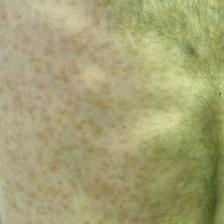

In [5]:
Monkeypox = list(data_dir.glob('Monkeypox/*.jpg'))
PIL.Image.open(str(Monkeypox[0]))


In [6]:
img = Image.open("./monkeypox/Others/NM15_02_11.jpg")  #这里选择你需要预测的图片
input_shape=np.asarray(img).shape


In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [8]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 2142 files belonging to 2 classes.
Using 1714 files for training.


In [9]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 2142 files belonging to 2 classes.
Using 428 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Monkeypox', 'Others']


In [11]:
# plt.figure(figsize=(20, 10))

# for images, labels in train_ds.take(1):
#     for i in range(20):
#         ax = plt.subplot(5, 10, i + 1)

#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
        
#         plt.axis("off")


In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 224, 224, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# 自定义卷积网络
## Inception ConvBNRelu


In [14]:
class ConvBNRelu(Model):
    def __init__(self, ch, kernelsz=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(ch, kernelsz, strides=strides, padding=padding),
            BatchNormalization(),
            Activation('relu')
        ])

    def call(self, x):
        x = self.model(x, training=False) #在training=False时，BN通过整个训练集计算均值、方差去做批归一化，training=True时，通过当前batch的均值、方差去做批归一化。推理时 training=False效果好
        return x


class InceptionBlk(Model):
    def __init__(self, ch, strides=1):
        super(InceptionBlk, self).__init__()
        self.ch = ch
        self.strides = strides
        self.c1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_2 = ConvBNRelu(ch, kernelsz=3, strides=1)
        self.c3_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c3_2 = ConvBNRelu(ch, kernelsz=5, strides=1)
        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.c4_2 = ConvBNRelu(ch, kernelsz=1, strides=strides)

    def call(self, x):
        x1 = self.c1(x)
        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)
        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)
        x4_1 = self.p4_1(x)
        x4_2 = self.c4_2(x4_1)
        # concat along axis=channel
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x


class Inception10(Model):
    def __init__(self, num_blocks, num_classes, init_ch=16, **kwargs):
        super(Inception10, self).__init__(**kwargs)
        self.in_channels = init_ch
        self.out_channels = init_ch
        self.num_blocks = num_blocks
        self.init_ch = init_ch
        self.c1 = tf.keras.models.Sequential([
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
            Conv2D(init_ch, 3, strides=1, padding='same',input_shape=input_shape),
            BatchNormalization(),
            Activation('relu')
        ])
        self.blocks = tf.keras.models.Sequential()
        for block_id in range(num_blocks):
            for layer_id in range(2):
                if layer_id == 0:
                    block = InceptionBlk(self.out_channels, strides=2)
                else:
                    block = InceptionBlk(self.out_channels, strides=1)
                self.blocks.add(block)
            # enlarger out_channels per block
            self.out_channels *= 2
        self.p1 = GlobalAveragePooling2D()
        self.f1 = Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.blocks(x)
        x = self.p1(x)
        y = self.f1(x)
        return y

```
tf.keras.optimizers.Adam(  
    learning_rate=0.001,  # 学习率 默认 0.001  
    beta_1=0.9,  # 一阶矩估计的指数衰减率。 默认 0.9  
    beta_2=0.999,  # 二阶矩估计的指数衰减率。 默认 0.999  
    epsilon=1e-07,  # 模糊因子。如果None，默认为K.epsilon()。该参数是非常小的数，其为了防止在实现中除以零。默认 1e-07  
    amsgrad=False,  # 布尔。是否应用该算法的AMSGrad变体。默认 False  
    name='Adam',  # 应用渐变时创建的操作的可选名称。  
    **kwargs)
```

In [ ]:
model = Inception10(num_blocks=2, num_classes=2)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

checkpoint_save_path = "./checkpoint0/Inception10.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(train_ds, batch_size=32, epochs=20, validation_data=val_ds, validation_freq=1,
                    callbacks=[cp_callback])

model.summary()


Epoch 1/20
54/54 [==============================] - 83s 2s/step - loss: 0.6796 - accuracy: 0.5758 - val_loss: 0.7190 - val_accuracy: 0.5350
Epoch 2/20
54/54 [==============================] - 81s 2s/step - loss: 0.6185 - accuracy: 0.6643 - val_loss: 0.8008 - val_accuracy: 0.5350
Epoch 3/20
54/54 [==============================] - 81s 2s/step - loss: 0.6202 - accuracy: 0.6641 - val_loss: 0.6939 - val_accuracy: 0.5537
Epoch 4/20
54/54 [==============================] - 81s 2s/step - loss: 0.6119 - accuracy: 0.6843 - val_loss: 0.7584 - val_accuracy: 0.5561
Epoch 5/20
54/54 [==============================] - 81s 2s/step - loss: 0.5936 - accuracy: 0.6834 - val_loss: 0.7513 - val_accuracy: 0.6238
Epoch 6/20
53/54 [============================>.] - ETA: 1s - loss: 0.5842 - accuracy: 0.6923

# 增加正则项，数据量较大，故使用l2正则化
class ConvBNRelu(Model):
    def __init__(self, ch, kernelsz=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(ch, kernelsz, strides=strides, padding=padding, kernel_regularizer=keras.regularizers.l2(0.002)),
            BatchNormalization(),
            Activation('relu')
        ])

    def call(self, x):
        x = self.model(x, training=False) #在training=False时，BN通过整个训练集计算均值、方差去做批归一化，training=True时，通过当前batch的均值、方差去做批归一化。推理时 training=False效果好
        return x

# 增加dropout层
class InceptionBlk(Model):
    def __init__(self, ch, strides=1):
        super(InceptionBlk, self).__init__()
        self.ch = ch
        self.strides = strides
        self.c1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_2 = ConvBNRelu(ch, kernelsz=3, strides=1)
        self.c3_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c3_2 = ConvBNRelu(ch, kernelsz=5, strides=1)
        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.d1 = layers.Dropout(0.2)
        self.c4_2 = ConvBNRelu(ch, kernelsz=1, strides=strides)

    def call(self, x):
        x1 = self.c1(x)
        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)
        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)
        x4_1 = self.p4_1(x)
        x4_1 = self.d1(x4_1)
        x4_2 = self.c4_2(x4_1)
        # concat along axis=channel
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x

# 增加dropout层
class Inception10(Model):
    def __init__(self, num_blocks, num_classes, init_ch=16, **kwargs):
        super(Inception10, self).__init__(**kwargs)
        self.in_channels = init_ch
        self.out_channels = init_ch
        self.num_blocks = num_blocks
        self.init_ch = init_ch
        self.c1 = tf.keras.models.Sequential([
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
            Conv2D(init_ch, 3, strides=1, padding='same',input_shape=input_shape),
            BatchNormalization(),
            Activation('relu')
        ])
        self.blocks = tf.keras.models.Sequential()
        for block_id in range(num_blocks):
            for layer_id in range(2):
                if layer_id == 0:
                    block = InceptionBlk(self.out_channels, strides=2)
                else:
                    block = InceptionBlk(self.out_channels, strides=1)
                self.blocks.add(block)
            # enlarger out_channels per block
            self.out_channels *= 2
        self.p1 = GlobalAveragePooling2D()
        self.d1 = layers.Dropout(0.1)
        self.f1 = Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.blocks(x)
        x = self.p1(x)
        x = self.d1(x)
        y = self.f1(x)
        return y

## InceptionBlk

In [19]:
num_classes = 2

"""
关于卷积核的计算不懂的可以参考文章：https://blog.csdn.net/qq_38251616/article/details/114278995

layers.Dropout(0.4) 作用是防止过拟合，提高模型的泛化能力。
在上一篇文章花朵识别中，训练准确率与验证准确率相差巨大就是由于模型过拟合导致的

关于Dropout层的更多介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/115826689
"""

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3  
    layers.AveragePooling2D((2, 2)),               # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.AveragePooling2D((2, 2)),               # 池化层2，2*2采样
    layers.Dropout(0.3),  
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    layers.Dropout(0.3),  
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 54, 54, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [20]:
# 设置优化器
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 50

checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[checkpointer])


Epoch 1/50
54/54 [==============================] - 17s 282ms/step - loss: 0.7568 - accuracy: 0.5472 - val_loss: 0.6678 - val_accuracy: 0.5888

Epoch 00001: val_accuracy improved from -inf to 0.58879, saving model to best_model.h5
Epoch 2/50
54/54 [==============================] - 15s 273ms/step - loss: 0.6642 - accuracy: 0.6100 - val_loss: 0.6327 - val_accuracy: 0.6542

Epoch 00002: val_accuracy improved from 0.58879 to 0.65421, saving model to best_model.h5
Epoch 3/50
54/54 [==============================] - 15s 271ms/step - loss: 0.6056 - accuracy: 0.6790 - val_loss: 0.6968 - val_accuracy: 0.6238

Epoch 00003: val_accuracy did not improve from 0.65421
Epoch 4/50
54/54 [==============================] - 15s 270ms/step - loss: 0.5847 - accuracy: 0.6888 - val_loss: 0.5944 - val_accuracy: 0.7009

Epoch 00004: val_accuracy improved from 0.65421 to 0.70093, saving model to best_model.h5
Epoch 5/50
54/54 [==============================] - 15s 270ms/step - loss: 0.5503 - accuracy: 0.7070 -


Epoch 00039: val_accuracy improved from 0.89252 to 0.89486, saving model to best_model.h5
Epoch 40/50
54/54 [==============================] - 15s 270ms/step - loss: 0.0629 - accuracy: 0.9847 - val_loss: 0.5047 - val_accuracy: 0.8645

Epoch 00040: val_accuracy did not improve from 0.89486
Epoch 41/50
54/54 [==============================] - 15s 271ms/step - loss: 0.0510 - accuracy: 0.9882 - val_loss: 0.4704 - val_accuracy: 0.8715

Epoch 00041: val_accuracy did not improve from 0.89486
Epoch 42/50
54/54 [==============================] - 15s 269ms/step - loss: 0.0435 - accuracy: 0.9940 - val_loss: 0.4735 - val_accuracy: 0.8738

Epoch 00042: val_accuracy did not improve from 0.89486
Epoch 43/50
54/54 [==============================] - 15s 269ms/step - loss: 0.0500 - accuracy: 0.9851 - val_loss: 0.4640 - val_accuracy: 0.8762

Epoch 00043: val_accuracy did not improve from 0.89486
Epoch 44/50
54/54 [==============================] - 15s 270ms/step - loss: 0.0462 - accuracy: 0.9872 - val_l

## 绘制acc曲线

In [ ]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure（figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Learning_rate 0.001 Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Learning_rate 0.001 Training and Validation Loss')
plt.legend()
plt.show()

## 观察曲线：
> - 发现训练集准确率超过95%，**说明模型是具有潜力的**。
> - 发现训练和验证集曲线**未**呈现出趋同，可能存在过拟合情况。
> - 发现曲线梯度较大，训练未完成

解决方案：
> - 缓解拟合：
> - - 1.设置舍弃层，舍弃部分参数；
> - - 2.正则化，sparse部分数据
> - 继续训练：
> - - 1.加大学习率
> - - 2.增加epoch

In [22]:
# 加载效果最好的模型权重
model.load_weights('best_model.h5')


In [31]:
from PIL import Image
import numpy as np

# img = Image.open("./45-data/Monkeypox/M06_01_04.jpg")  #这里选择你需要预测的图片
img = Image.open("./monkeypox/Others/NM15_02_11.jpg")  #这里选择你需要预测的图片
image = tf.image.resize(np.asarray(img), [img_height, img_width])

img_array = tf.expand_dims(image, 0) 

predictions = model.predict(img_array) # 这里选用你已经训练好的模型
print("预测结果为：",class_names[np.argmax(predictions)])


AttributeError: in user code:

    /root/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    <ipython-input-28-68b4d2cf9612>:75 call  *
        x = self.blocks(x)
    <ipython-input-28-68b4d2cf9612>:40 call  *
        x1 = self.c1(x)

    AttributeError: 'InceptionBlk' object has no attribute 'c1'


In [30]:
img

NameError: name 'img' is not defined